# Yelp Review Analysis MVP

This notebook analyzes Yelp restaurant reviews to:
- Classify sentiment (positive/negative)
- Find most common words
- Extract themes (Ambiance, Service, Crowdedness, etc.)
- Generate insights and visualizations


## Step 1: Install Dependencies

Run this cell first to install required packages (only needed once)


In [30]:
# Install required packages
%pip install pandas numpy nltk textblob scikit-learn matplotlib seaborn wordcloud vaderSentiment -q

# If you get NLTK errors, run this cell to download all NLTK data:
# import nltk
# nltk.download('all')


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries and Modules


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import json
import warnings
import os
warnings.filterwarnings('ignore')

# Set up plotting for Jupyter
%matplotlib inline
plt.style.use('default')
sns.set_palette("husl")

# Download NLTK data (required for word analysis)
# This MUST be done before importing word_analyzer
import nltk

# Set NLTK data path (cross-platform)
import platform
if platform.system() == 'Windows':
    nltk_data_dir = os.path.join(os.path.expanduser('~'), 'AppData', 'Roaming', 'nltk_data')
else:
    # Linux/Mac
    nltk_data_dir = os.path.join(os.path.expanduser('~'), 'nltk_data')

if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir, exist_ok=True)

# Add to NLTK path
if nltk_data_dir not in nltk.data.path:
    nltk.data.path.append(nltk_data_dir)

print("Downloading NLTK data (this may take a moment)...")
print("This is a one-time setup. Please wait...")
print(f"NLTK data directory: {nltk_data_dir}\n")

# Download with verbose output to see progress
try:
    nltk.download('punkt', quiet=False)
except:
    pass

try:
    nltk.download('punkt_tab', quiet=False)
except:
    pass  # punkt_tab may not be available in all versions

try:
    nltk.download('stopwords', quiet=False)
except:
    pass

try:
    nltk.download('wordnet', quiet=False)
except:
    pass

try:
    nltk.download('omw-1.4', quiet=False)  # WordNet data dependency
except:
    pass

# Verify downloads and test tokenization
print("\nVerifying NLTK data...")
try:
    nltk.data.find('tokenizers/punkt')
    print("✓ punkt tokenizer found")
    # Test tokenization
    from nltk.tokenize import word_tokenize
    test_tokens = word_tokenize("test sentence")
    print("✓ punkt tokenizer working")
except Exception as e:
    print(f"⚠ punkt tokenizer issue: {e}")
    print("Will use fallback tokenization if needed")

try:
    nltk.data.find('corpora/stopwords')
    print("✓ stopwords found")
except:
    print("⚠ stopwords not found - will download on first use")

try:
    nltk.data.find('corpora/wordnet')
    print("✓ wordnet found")
except:
    print("⚠ wordnet not found - will download on first use")

print("\n✓ NLTK setup complete\n")

# Import our analysis modules
from sentiment_analyzer import SentimentAnalyzer
from word_analyzer import WordAnalyzer
from theme_extractor import ThemeExtractor

print("✓ All modules imported successfully")


This is a one-time setup. Please wait...
NLTK data directory: C:\Users\arvid\AppData\Roaming\nltk_data


Verifying NLTK data...
✓ punkt tokenizer found
✓ punkt tokenizer working
✓ stopwords found
⚠ wordnet not found - will download on first use

✓ NLTK setup complete

✓ All modules imported successfully


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arvid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\arvid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arvid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arvid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\arvid\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Step 3: Load Yelp Dataset

Update the file path to point to your Yelp review dataset


In [ ]:
# Path to your Yelp review dataset
# IMPORTANT: Update this path to point to your Yelp review JSON file
# Examples:
#   Windows: DATA_FILE = r"C:\Users\YourName\Downloads\yelp_academic_dataset_review.json"
#   Mac/Linux: DATA_FILE = "/path/to/your/yelp_academic_dataset_review.json"
#   Relative: DATA_FILE = "yelp_academic_dataset_review.json"  # if file is in same directory

DATA_FILE = "yelp_academic_dataset_review.json"  # ⚠️ CHANGE THIS to your file path!

# Optional: Set sample size for faster testing (set to None to analyze all reviews)
SAMPLE_SIZE = 5000  # Set to None to analyze all reviews

# Check if file exists
if not os.path.exists(DATA_FILE):
    print(f"❌ ERROR: File not found: {DATA_FILE}")
    print(f"\nPlease update the DATA_FILE variable above with the correct path to your Yelp dataset.")
    print(f"\nCurrent working directory: {os.getcwd()}")
    print(f"\nTo find your file, you can:")
    print(f"  1. Use an absolute path (full path from root)")
    print(f"  2. Use a relative path (relative to current directory)")
    print(f"  3. Move your file to the current directory: {os.getcwd()}")
    raise FileNotFoundError(f"Yelp dataset file not found: {DATA_FILE}")

print(f"Loading data from {DATA_FILE}...")
file_size_mb = os.path.getsize(DATA_FILE) / (1024*1024)
print(f"File size: {file_size_mb:.2f} MB")

# Load JSON data (Yelp format: one JSON object per line)
reviews = []
try:
    with open(DATA_FILE, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            try:
                reviews.append(json.loads(line))
                if SAMPLE_SIZE and len(reviews) >= SAMPLE_SIZE:
                    break
            except json.JSONDecodeError:
                continue
            if (i + 1) % 10000 == 0:
                print(f"  Loaded {len(reviews)} reviews...")
except Exception as e:
    print(f"❌ Error loading file: {e}")
    raise

df = pd.DataFrame(reviews)
print(f"\n✓ Loaded {len(df)} reviews")
print(f"\nColumns: {list(df.columns)}")

# Identify text column
possible_text_cols = ['text', 'review_text', 'content', 'review', 'comment']
text_column = None
for col in possible_text_cols:
    if col in df.columns:
        text_column = col
        break

if text_column is None and len(df.columns) > 0:
    text_column = df.columns[0]
    print(f"⚠️  Warning: Using '{text_column}' as text column (not in standard list)")

print(f"\nUsing '{text_column}' as review text column")
df.head()


Loading data from C:\Users\arvid\Downloads\yelp_academic_dataset_review.json...
File size: 5094.40 MB

✓ Loaded 5000 reviews

Columns: ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']

Using 'text' as review text column


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


## Step 4: Sentiment Analysis


Analyzing sentiment...

Sentiment Distribution:
  Positive: 4331 (86.6%)
  Negative: 598 (12.0%)
  Neutral: 71 (1.4%)


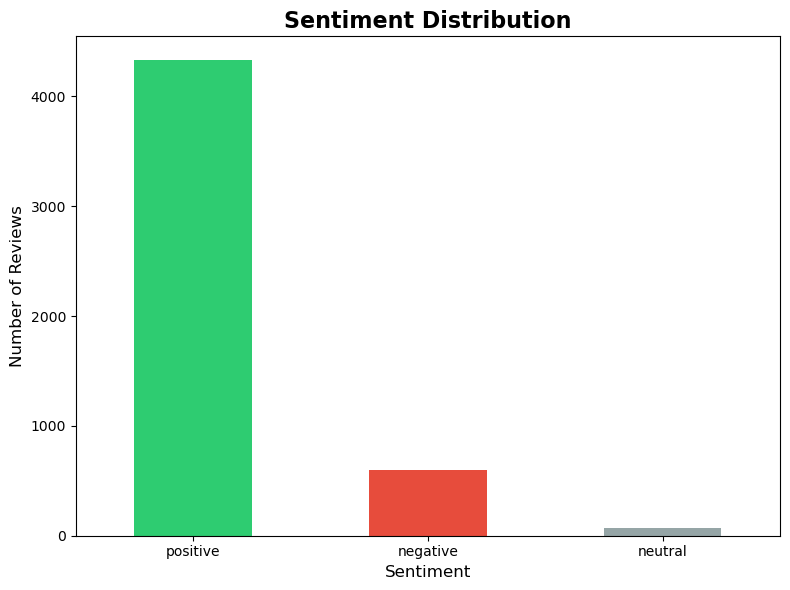


✓ Sentiment analysis complete


In [33]:
print("Analyzing sentiment...")

sentiment_analyzer = SentimentAnalyzer()
df = sentiment_analyzer.analyze_reviews(df, text_column=text_column, method='vader')

# Display sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
print("\nSentiment Distribution:")
for sentiment, count in sentiment_counts.items():
    pct = count / len(df) * 100
    print(f"  {sentiment.capitalize()}: {count} ({pct:.1f}%)")

# Visualize sentiment distribution
fig, ax = plt.subplots(figsize=(8, 6))
sentiment_counts.plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c', '#95a5a6'])
ax.set_title('Sentiment Distribution', fontsize=16, fontweight='bold')
ax.set_xlabel('Sentiment', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

print("\n✓ Sentiment analysis complete")


## Step 5: Word Frequency Analysis


In [34]:
print("Analyzing word frequencies...")

word_analyzer = WordAnalyzer()

# Get positive and negative reviews
positive_texts = df[df['sentiment'] == 'positive']['cleaned_text']
negative_texts = df[df['sentiment'] == 'negative']['cleaned_text']

print(f"  Analyzing {len(positive_texts)} positive reviews...")
top_positive_words = word_analyzer.get_top_words(positive_texts, top_n=30)

print(f"  Analyzing {len(negative_texts)} negative reviews...")
top_negative_words = word_analyzer.get_top_words(negative_texts, top_n=30)

# Get sentiment-specific words
positive_word_freq = word_analyzer.get_word_frequencies(positive_texts)
negative_word_freq = word_analyzer.get_word_frequencies(negative_texts)
sentiment_specific = word_analyzer.get_sentiment_specific_words(
    positive_word_freq, 
    negative_word_freq, 
    top_n=20
)

print("\n✓ Word frequency analysis complete")


Analyzing word frequencies...
  Analyzing 4331 positive reviews...


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arvid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\arvid\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


  Analyzing 598 negative reviews...

✓ Word frequency analysis complete


### Top Words Visualization


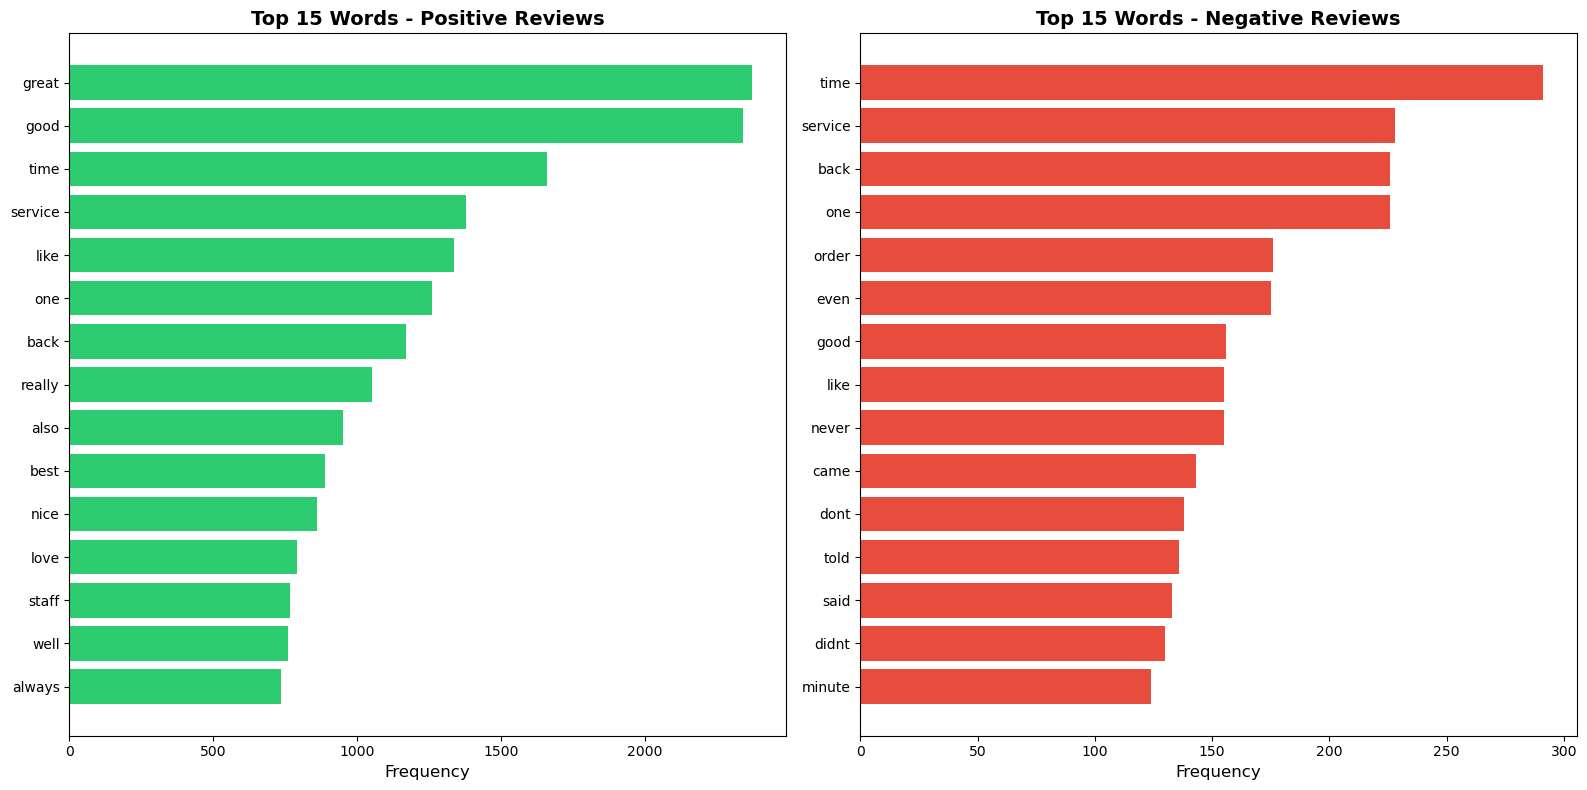

In [35]:
# Create side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Positive words
pos_words = dict(top_positive_words[:15])
ax1.barh(range(len(pos_words)), list(pos_words.values()), color='#2ecc71')
ax1.set_yticks(range(len(pos_words)))
ax1.set_yticklabels(list(pos_words.keys()))
ax1.set_xlabel('Frequency', fontsize=12)
ax1.set_title('Top 15 Words - Positive Reviews', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# Negative words
neg_words = dict(top_negative_words[:15])
ax2.barh(range(len(neg_words)), list(neg_words.values()), color='#e74c3c')
ax2.set_yticks(range(len(neg_words)))
ax2.set_yticklabels(list(neg_words.keys()))
ax2.set_xlabel('Frequency', fontsize=12)
ax2.set_title('Top 15 Words - Negative Reviews', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()


### Sentiment-Specific Words


In [36]:
print("✅ WORDS MORE COMMON IN POSITIVE REVIEWS:")
for i, (word, data) in enumerate(sentiment_specific['positive_specific'][:15], 1):
    ratio = data['ratio']
    print(f"   {i:2d}. {word:15s} (ratio: {ratio:.2f}x)")

print("\n❌ WORDS MORE COMMON IN NEGATIVE REVIEWS:")
for i, (word, data) in enumerate(sentiment_specific['negative_specific'][:15], 1):
    ratio = data['ratio']
    print(f"   {i:2d}. {word:15s} (ratio: {ratio:.2f}x)")


✅ WORDS MORE COMMON IN POSITIVE REVIEWS:
    1. wonderful       (ratio: 15.62x)
    2. delicious       (ratio: 12.54x)
    3. amazing         (ratio: 12.53x)
    4. loved           (ratio: 11.30x)
    5. friendly        (ratio: 10.90x)
    6. enjoyed         (ratio: 10.32x)
    7. perfect         (ratio: 9.81x)
    8. perfectly       (ratio: 9.11x)
    9. pleasant        (ratio: 7.42x)
   10. excellent       (ratio: 7.16x)
   11. favorite        (ratio: 7.10x)
   12. donut           (ratio: 6.63x)
   13. helpful         (ratio: 6.41x)
   14. glad            (ratio: 6.37x)
   15. ambiance        (ratio: 6.23x)

❌ WORDS MORE COMMON IN NEGATIVE REVIEWS:
    1. unprofessional  (ratio: 49.97x)
    2. crappy          (ratio: 26.17x)
    3. disgusting      (ratio: 22.31x)
    4. poop            (ratio: 21.41x)
    5. yelled          (ratio: 21.41x)
    6. rim             (ratio: 21.41x)
    7. unfortunate     (ratio: 21.41x)
    8. edible          (ratio: 21.41x)
    9. strike          (ratio

### Word Clouds


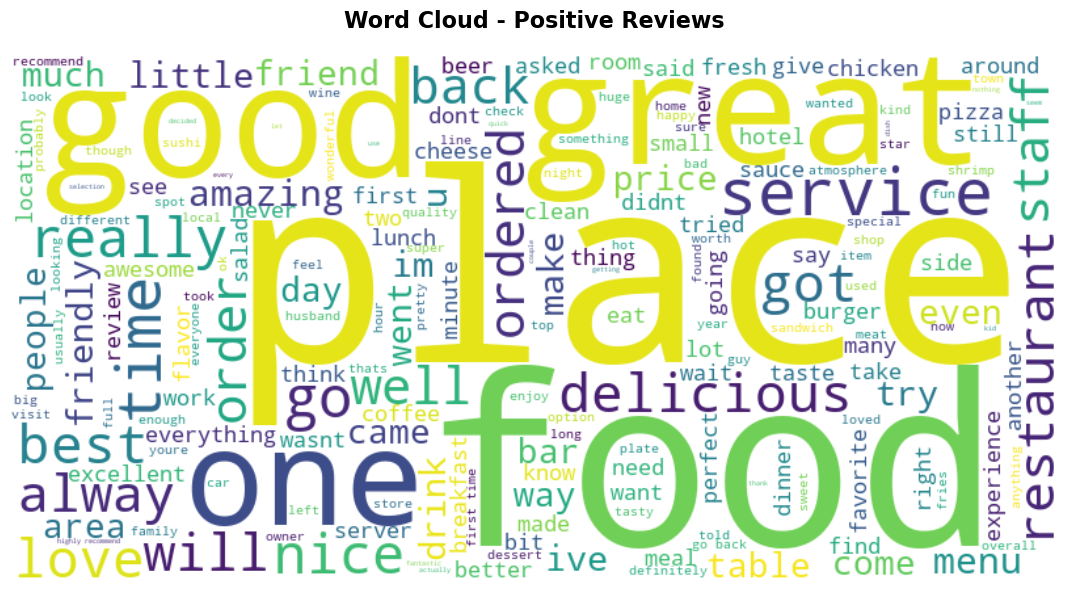

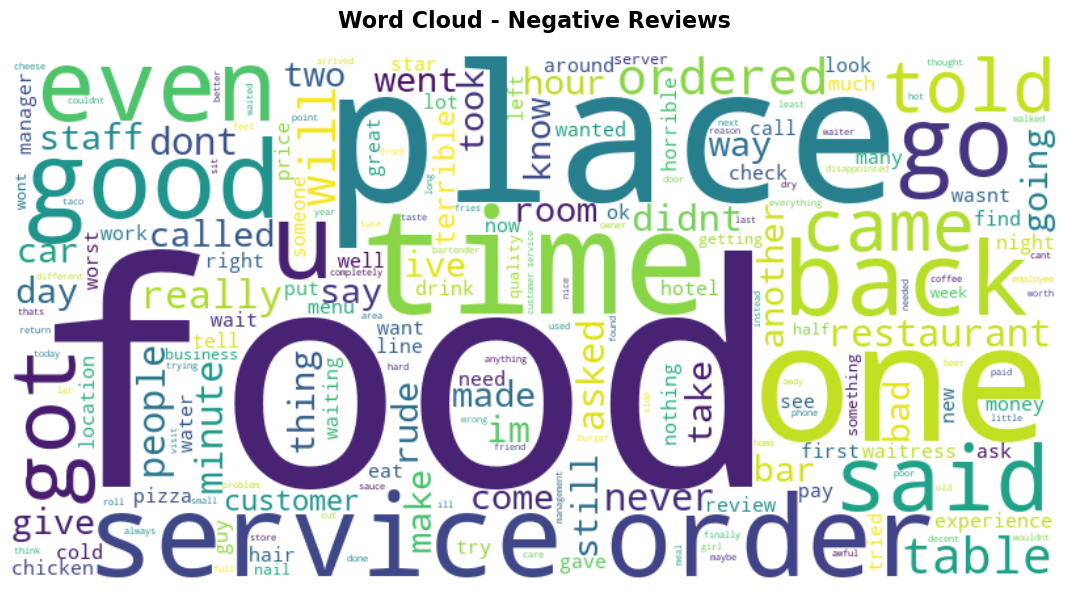

In [37]:
# Positive word cloud
positive_text = ' '.join(positive_texts.astype(str))
if positive_text.strip():
    wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud_pos, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud - Positive Reviews', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

# Negative word cloud
negative_text = ' '.join(negative_texts.astype(str))
if negative_text.strip():
    wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud_neg, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud - Negative Reviews', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


## Step 6: Theme Extraction


In [38]:
print("Extracting themes...")

theme_extractor = ThemeExtractor()
df = theme_extractor.extract_themes_from_reviews(df)
theme_insights = theme_extractor.get_theme_insights(df)

print("\n✓ Theme extraction complete")


Extracting themes...

✓ Theme extraction complete


### Theme Analysis Visualization


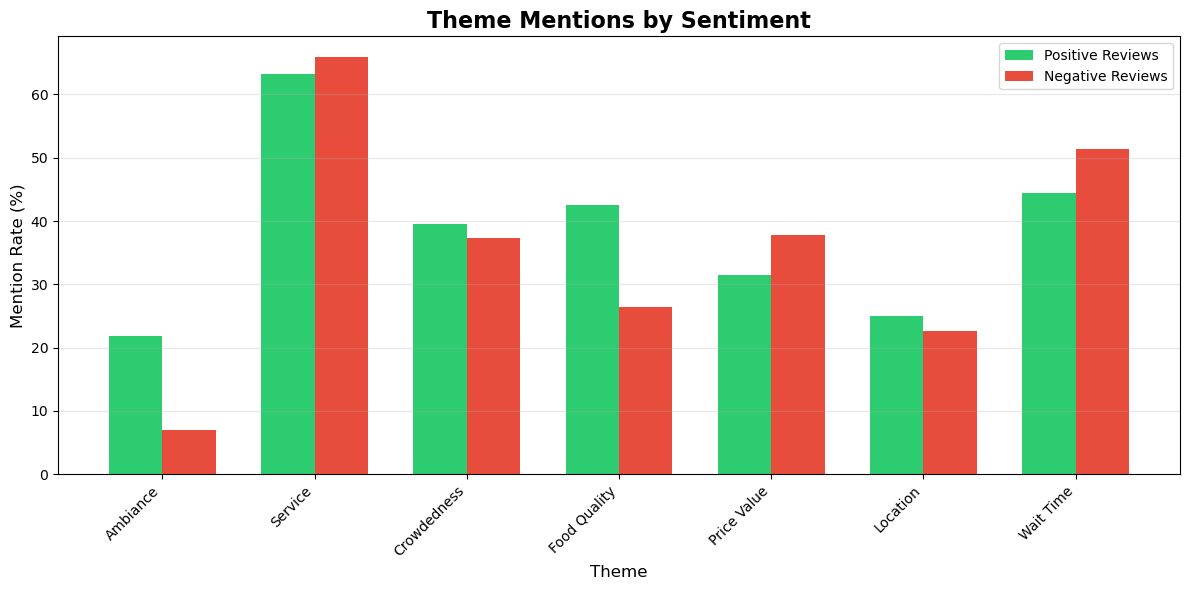

In [39]:
# Theme mentions by sentiment
themes = list(theme_insights.keys())
pos_rates = [theme_insights[t]['positive_mention_rate'] for t in themes]
neg_rates = [theme_insights[t]['negative_mention_rate'] for t in themes]

x = np.arange(len(themes))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, pos_rates, width, label='Positive Reviews', color='#2ecc71')
ax.bar(x + width/2, neg_rates, width, label='Negative Reviews', color='#e74c3c')

ax.set_xlabel('Theme', fontsize=12)
ax.set_ylabel('Mention Rate (%)', fontsize=12)
ax.set_title('Theme Mentions by Sentiment', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([t.replace('_', ' ').title() for t in themes], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### Theme Insights Summary


In [40]:
print("🎯 THEME INSIGHTS:\n")
for theme, insight in theme_insights.items():
    pos_pct = insight['positive_mention_rate']
    neg_pct = insight['negative_mention_rate']
    diff = insight['difference']
    direction = "more in positive" if insight['more_in_positive'] else "more in negative"
    
    print(f"{theme.upper().replace('_', ' ')}:")
    print(f"  Positive reviews: {pos_pct:.1f}% mention this theme")
    print(f"  Negative reviews: {neg_pct:.1f}% mention this theme")
    print(f"  Difference: {diff:+.1f}% ({direction})")
    print()


🎯 THEME INSIGHTS:

AMBIANCE:
  Positive reviews: 21.8% mention this theme
  Negative reviews: 7.0% mention this theme
  Difference: +14.8% (more in positive)

SERVICE:
  Positive reviews: 63.2% mention this theme
  Negative reviews: 65.9% mention this theme
  Difference: -2.7% (more in negative)

CROWDEDNESS:
  Positive reviews: 39.6% mention this theme
  Negative reviews: 37.3% mention this theme
  Difference: +2.3% (more in positive)

FOOD QUALITY:
  Positive reviews: 42.6% mention this theme
  Negative reviews: 26.4% mention this theme
  Difference: +16.1% (more in positive)

PRICE VALUE:
  Positive reviews: 31.5% mention this theme
  Negative reviews: 37.8% mention this theme
  Difference: -6.3% (more in negative)

LOCATION:
  Positive reviews: 25.0% mention this theme
  Negative reviews: 22.6% mention this theme
  Difference: +2.4% (more in positive)

WAIT TIME:
  Positive reviews: 44.4% mention this theme
  Negative reviews: 51.3% mention this theme
  Difference: -6.9% (more in n

## Step 7: Summary Statistics


In [41]:
print("="*60)
print("ANALYSIS SUMMARY")
print("="*60)

print("\n📊 SENTIMENT DISTRIBUTION:")
for sentiment, count in sentiment_counts.items():
    pct = count / len(df) * 100
    print(f"   {sentiment.capitalize()}: {count} ({pct:.1f}%)")

print("\n📝 TOP WORDS IN POSITIVE REVIEWS:")
for i, (word, freq) in enumerate(top_positive_words[:10], 1):
    print(f"   {i:2d}. {word:15s} ({freq:4d} mentions)")

print("\n📝 TOP WORDS IN NEGATIVE REVIEWS:")
for i, (word, freq) in enumerate(top_negative_words[:10], 1):
    print(f"   {i:2d}. {word:15s} ({freq:4d} mentions)")

print("\n🎯 KEY THEME FINDINGS:")
for theme, insight in sorted(theme_insights.items(), key=lambda x: abs(x[1]['difference']), reverse=True)[:5]:
    diff = insight['difference']
    direction = "positive" if insight['more_in_positive'] else "negative"
    print(f"   {theme.replace('_', ' ').title()}: {abs(diff):.1f}% more in {direction} reviews")


ANALYSIS SUMMARY

📊 SENTIMENT DISTRIBUTION:
   Positive: 4331 (86.6%)
   Negative: 598 (12.0%)
   Neutral: 71 (1.4%)

📝 TOP WORDS IN POSITIVE REVIEWS:
    1. great           (2373 mentions)
    2. good            (2342 mentions)
    3. time            (1662 mentions)
    4. service         (1380 mentions)
    5. like            (1336 mentions)
    6. one             (1260 mentions)
    7. back            (1170 mentions)
    8. really          (1051 mentions)
    9. also            ( 951 mentions)
   10. best            ( 889 mentions)

📝 TOP WORDS IN NEGATIVE REVIEWS:
    1. time            ( 291 mentions)
    2. service         ( 228 mentions)
    3. back            ( 226 mentions)
    4. one             ( 226 mentions)
    5. order           ( 176 mentions)
    6. even            ( 175 mentions)
    7. good            ( 156 mentions)
    8. like            ( 155 mentions)
    9. never           ( 155 mentions)
   10. came            ( 143 mentions)

🎯 KEY THEME FINDINGS:
   Food Qual